## Library imports

In [89]:
#Import all the necessary libraries and store data in Dataframe
import pandas as pd

from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import matplotlib as mt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,precision_recall_curve,confusion_matrix, classification_report,f1_score,auc,fbeta_score
from imblearn.over_sampling import SMOTE
import  xgboost as xgb
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,LabelEncoder





In [102]:
df = pd.read_csv("D:\\ASDS\\ASDS 5302\\Final Project\\healthcare-dataset-stroke-data.csv")
df_stroke = df.copy()

df_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### About Dataset:
1) id: subject ID number
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have heart disease, 1 if the patient has heart 
disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_job", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" o("Unknown" in smoking_status means that the information is unavailable)
13Unknown"
12) stroke: 1 if the patient  or 0 if nothad a st this patient


# Data Preprocessing

To achieve meaningful and accurate results, data preprocessing is a crucial first step. This involves cleaning the data, handling missing values, encoding categorical variables, and removing redundant columns.

Our dataset consists of 12 columns and 5,110 records, some of which contain unnecessary or incomplete information, making cleaning essential.


•	Missing Values: The BMI field contains missing values, which were imputed using the MICE (Multiple Imputation by Chained Equations) technique to ensure accuracy and completeness.

•	Encoding Categorical Variables: One-hot encoding was applied to all categorical variables using pd.get_dummies(), creating separate columns for each category.

•	Reducing Dimensions: After encoding, redundant columns that provided the same information were removed to reduce dataset dimensions. Examples include: \n
    1) Gender_Male and Gender_Female columns: One was removed as they convey the same information. \n
    2) Ever_married_Yes and Ever_married_No columns: One was eliminated to avoid redundancy. \n
    3) Id column: Removed as it is irrelevant to the analysis. \n


In [103]:
#Since we have only 1 row with other gender removing this row
df_stroke=df_stroke[df_stroke['gender']!='Other']
# Since ID is not useful removing it
df_stroke = df_stroke.drop(['id'], axis = 1)
df_stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Check if there are any missing or null values in the dataset

In [104]:
df_stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We can observe the bmi contains 201 null values in the dataset which is 3% of the data

Since it is a numerical value check if data is is normally distributed to apply mean else apply median.

<Axes: xlabel='bmi', ylabel='Count'>

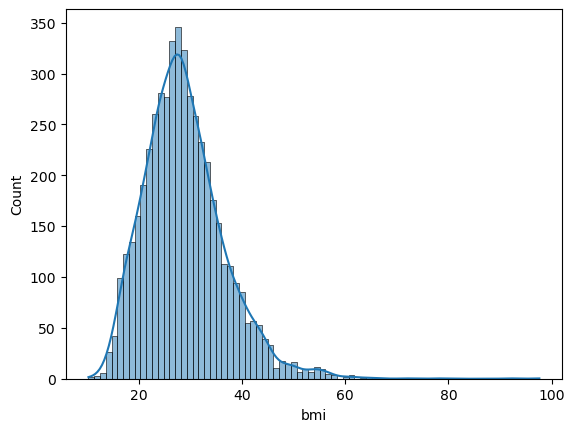

In [6]:
#BMI Distribution
sns.histplot(x='bmi',data=df_stroke,kde=True)
#Data is skewed hence apply median or mice imputation

In [84]:
print(f"BMI: Min->{df_stroke['bmi'].min()} \t Max->{df_stroke['bmi'].max()} \n Mean -> {df_stroke['bmi'].mean()} \n Median-> {df_stroke['bmi'].median()} \n Mode -> {df_stroke['bmi'].mode()[0]}")

BMI: Min->10.3 	 Max->97.6 
 Mean -> 28.894559902200488 
 Median-> 28.1 
 Mode -> 28.7


In [105]:
#MICE imputation for BMI
# need to enable iterative imputer explicitly since its still experimental
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

df_train= df_stroke.loc[:,['age','avg_glucose_level','bmi']]
df_train.head()


imputer=IterativeImputer(estimator=RandomForestRegressor(random_state=100),random_state=48)
imputer.fit(df_train)
df_imputed = imputer.transform(df_train)
df_imputed
df_stroke.loc[:,['age','avg_glucose_level','bmi']] = df_imputed
df_stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,37.033,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,26.958,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600,formerly smoked,0


<Axes: xlabel='bmi', ylabel='Count'>

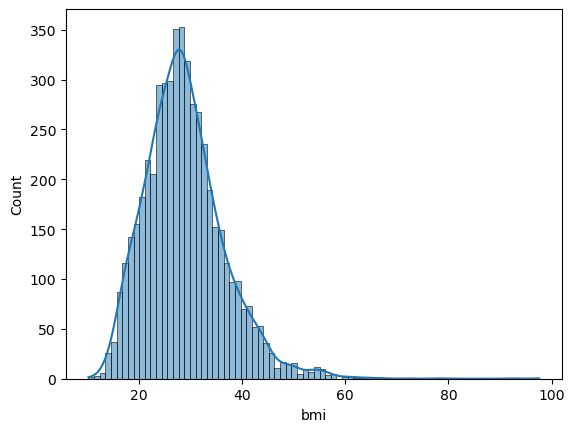

In [10]:
#BMI Distribution after mice imputation
sns.histplot(x='bmi',data=df_stroke,kde=True)
#

In [11]:
print(f"BMI: Min->{df_stroke['bmi'].min()} \t Max->{df_stroke['bmi'].max()} \n Mean -> {df_stroke['bmi'].mean()} \n Median-> {df_stroke['bmi'].median()} \n Mode -> {df_stroke['bmi'].mode()[0]}")

BMI: Min->10.3 	 Max->97.6 
 Mean -> 28.944337427881706 
 Median-> 28.2 
 Mode -> 28.7


<Axes: xlabel='age', ylabel='Count'>

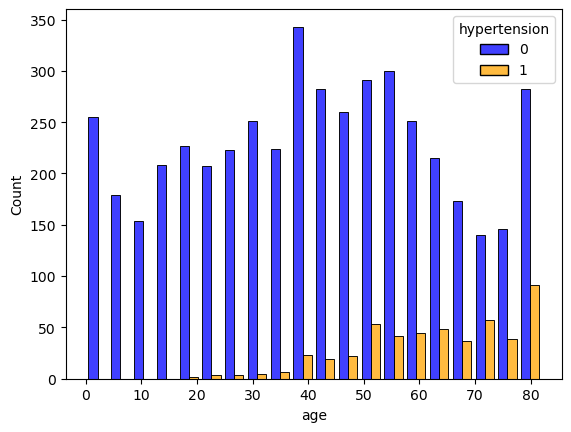

In [224]:
#Age Vs hypertension DISTRIBUTION
custom_palette = {0: 'blue', 1: 'orange'}
sns.histplot(x='age',hue='hypertension',stat='count',binwidth=4,data=df_stroke,palette=custom_palette,multiple='dodge',shrink=0.8)

<Axes: xlabel='age', ylabel='Count'>

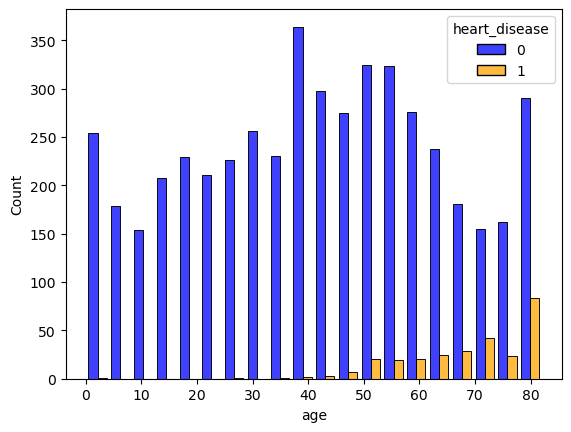

In [16]:
#Age Vs heart_disease DISTRIBUTION
custom_palette = {0: 'blue', 1: 'orange'}
sns.histplot(x='age',hue='heart_disease',stat='count',binwidth=4,data=df_stroke,palette=custom_palette,multiple='dodge',shrink=0.8)

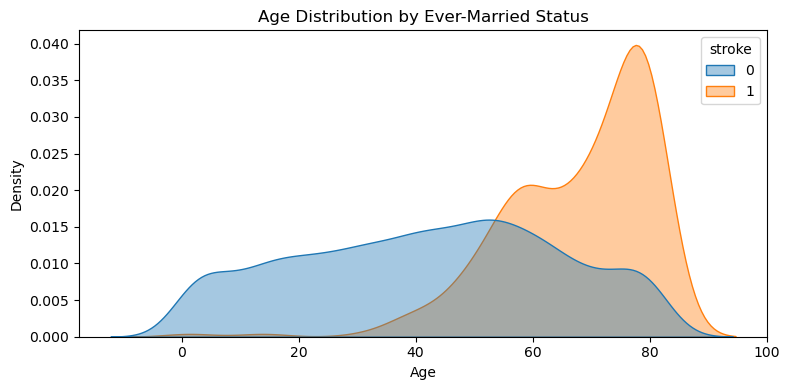

In [9]:
plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df,x="age",hue="stroke",common_norm=False,fill=True, alpha=0.4)
plt.title("Age Distribution by Ever-Married Status")
plt.xlabel("Age")
plt.tight_layout()
plt.show()


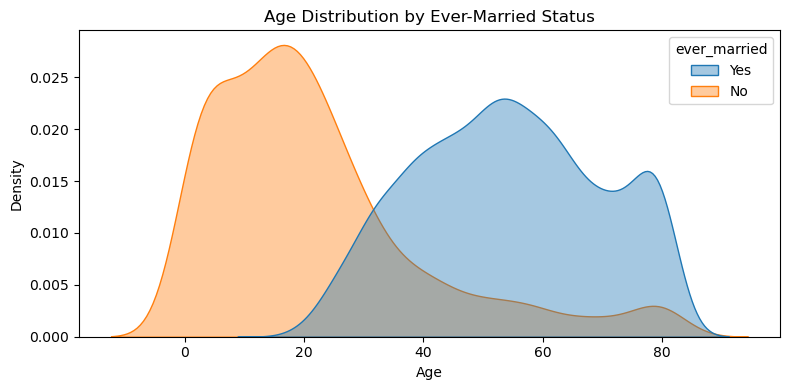

In [41]:
plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df,x="age",hue="ever_married",common_norm=False,fill=True, alpha=0.4)
plt.title("Age Distribution by Ever-Married Status")
plt.xlabel("Age")
plt.tight_layout()
plt.show()

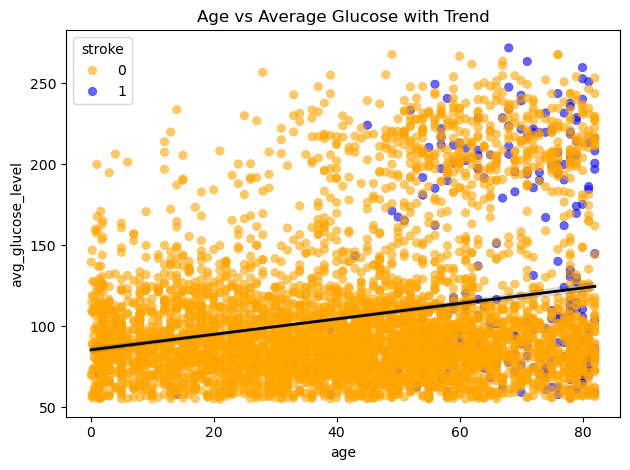

In [25]:
#AGE Vs Avg_Glucose_Level Vs Stroke
custom_palette = {1:"blue",0:"orange"}
sns.scatterplot(x='age',y='avg_glucose_level',hue='stroke',data=df,palette=custom_palette,alpha=0.6,edgecolor=None)
sns.regplot(data=df,x="age",y='avg_glucose_level',scatter=False,color='black',line_kws={"linewidth":2})
plt.title("Age vs Average Glucose with Trend")
plt.tight_layout()
plt.show()

<Axes: xlabel='bmi', ylabel='Count'>

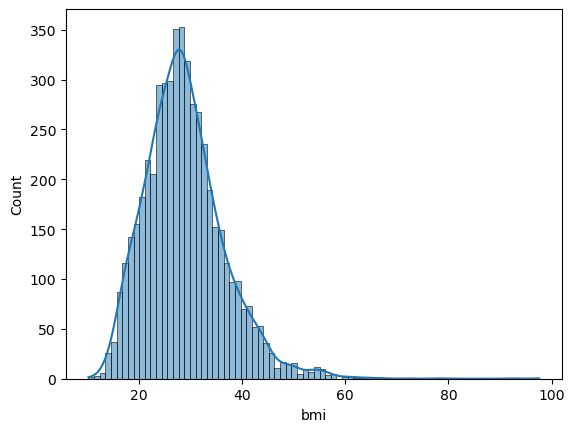

In [227]:
#BMI Distribution after MICE Imputation
sns.histplot(x='bmi',data=df_stroke,kde=True)

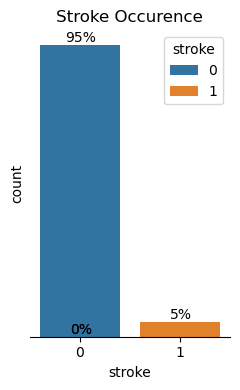

In [64]:
#Stroke Distribution
plt.figure(figsize=(2.5,4))
ax=sns.countplot(x='stroke',hue='stroke',data=df_stroke)
sns.despine(top=True, right=True, left=True, bottom=False)

ax.set_yticks([])
plt.title("Stroke Occurence")
total=df_stroke['stroke'].count()
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/total, '.0f')+'%', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (1, 5), textcoords = 'offset points')
plt.tight_layout()
plt.show()

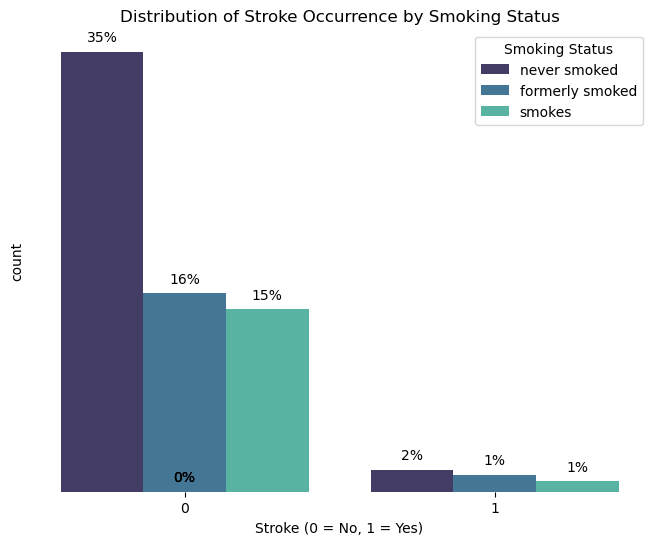

In [229]:
#Distribution of Stroke Occurrence by Smoking Status
plt.figure(figsize=(8, 6))

ax=sns.countplot(x='stroke', hue='smoking_status',hue_order = ['never smoked','formerly smoked', 'smokes'],
                 stat='count',palette="mako",data=df_stroke,legend="brief")

ax.set_yticks([])
plt.title('Distribution of Stroke Occurrence by Smoking Status')
plt.xlabel('Stroke (0 = No, 1 = Yes)')
#plt.ylabel('Count')
plt.legend(title='Smoking Status')
for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)
total=df['id'].count()
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/total, '.0f')+'%', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

C:\Users\gamer\AppData\Local\Temp\ipykernel_16984\3375776055.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels( labels = ['Children', 'Teens', 'Adults', 'Mid Adults', 'Elderly'],fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
C:\Users\gamer\AppData\Local\Temp\ipykernel_16984\3375776055.py:67: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df_stroke, x = 'age', ax = ax2, shade = True, color = '#882599EA',alpha = 1, )
C:\Users\gamer\AppData\Local\Temp\ipykernel_16984\3375776055.py:83: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df_stroke[df_stroke['stroke'] == 0], x = 'age',ax = ax3, shade = 

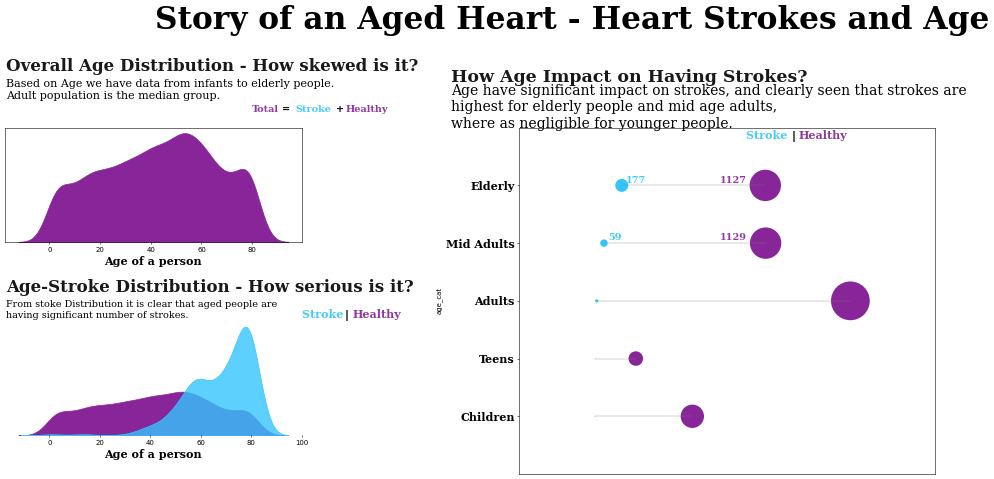

In [11]:

df_stroke['bmi_cat'] = pd.cut(df_stroke['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df_stroke['age_cat'] = pd.cut(df_stroke['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
df_stroke['glucose_cat'] = pd.cut(df_stroke['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

fig = plt.figure(figsize = (24,10), dpi = 50)

gs = fig.add_gridspec(10,24)
gs.update(wspace = 1, hspace = 0.05)


ax2 = fig.add_subplot(gs[1:4,0:8]) #distribution plot
ax3 = fig.add_subplot(gs[6:9, 0:8]) #hue distribution plot
ax1 = fig.add_subplot(gs[1:10,13:]) #dumbbell plot

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    #ax.set_facecolor('#f6f5f5')
    
for loc in ['left', 'right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)

#fig.patch.set_facecolor('#f6f5f5')
        
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(True)

# dumbbell plot of stoke and healthy people

stroke_age = df_stroke[df_stroke['stroke'] == 1].age_cat.value_counts()
healthy_age = df_stroke[df_stroke['stroke'] == 0].age_cat.value_counts()

ax1.hlines(y = ['Children', 'Teens', 'Adults', 'Mid Adults', 'Elderly'], xmin = [644,270,1691,1129,1127], 
          xmax = [1,1,11,59,177], color = 'grey',**{'linewidth':0.5})


sns.scatterplot(y = stroke_age.index, x = stroke_age.values, s = stroke_age.values*2, color = '#34c5fee6', ax= ax1, alpha = 1)
sns.scatterplot(y = healthy_age.index, x = healthy_age.values, s = healthy_age.values*2, color = '#882599EA', ax= ax1, alpha = 1)

ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlim(xmin = -500, xmax = 2250)
ax1.set_ylim(ymin = -1,ymax = 5)

ax1.set_yticklabels( labels = ['Children', 'Teens', 'Adults', 'Mid Adults', 'Elderly'],fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

ax1.text(-950,5.8, 'How Age Impact on Having Strokes?' ,{'font': 'Serif', 'size': '25','weight':'bold', 'color':'black'},alpha = 0.9)
ax1.text(1000,4.8, 'Stroke ', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#34c5fee6'})
ax1.text(1300,4.8, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax1.text(1350,4.8, 'Healthy', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':'#882599EA'})
ax1.text(-950,5., 'Age have significant impact on strokes, and clearly seen that strokes are \nhighest for elderly people and mid age adults, \nwhere as negligible for younger people.', 
        {'font':'Serif', 'size':'20','color': 'black'})

ax1.text(stroke_age.values[0] + 30,4.05, stroke_age.values[0], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#34c5fee6'})
ax1.text(healthy_age.values[2] - 300,4.05, healthy_age.values[2], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#882599EA'})

ax1.text(stroke_age.values[1] + 30,3.05, stroke_age.values[1], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#34c5fee6'})
ax1.text(healthy_age.values[1] - 300,3.05, healthy_age.values[1], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#882599EA'})




# distribution plots ---- only single variable

sns.kdeplot(data = df_stroke, x = 'age', ax = ax2, shade = True, color = '#882599EA',alpha = 1, )
ax2.set_xlabel('Age of a person', fontdict = {'font':'Serif', 'color': 'black', 'size': 16,'weight':'bold' })
ax2.text(-17,0.025,'Overall Age Distribution - How skewed is it?', {'font':'Serif', 'color': 'black','weight':'bold','size':24}, alpha = 0.9)
ax2.text(-17,0.021, 'Based on Age we have data from infants to elderly people.\nAdult population is the median group.', 
        {'font':'Serif', 'size':'16','color': 'black'})
ax2.text(80,0.019, 'Total',{'font':'Serif', 'size':'14','color': '#882599EA','weight':'bold'})
ax2.text(92,0.019, '=',{'font':'Serif', 'size':'14','color': 'black','weight':'bold'})
ax2.text(97,0.019, 'Stroke',{'font':'Serif', 'size':'14','color': "#34c5fee6",'weight':'bold'})
ax2.text(113,0.019, '+',{'font':'Serif', 'size':'14','color': 'black','weight':'bold'})
ax2.text(117,0.019, 'Healthy',{'font':'Serif', 'size':'14','color': '#882599EA','weight':'bold'})



# distribution plots with hue of strokes


sns.kdeplot(data = df_stroke[df_stroke['stroke'] == 0], x = 'age',ax = ax3, shade = True,  alpha = 1, color = '#882599EA' )
sns.kdeplot(data = df_stroke[df_stroke['stroke'] == 1], x = 'age',ax = ax3, shade = True,  alpha = 0.8, color = '#34c5fee6')

ax3.set_xlabel('Age of a person', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})

ax3.text(-17,0.0525,'Age-Stroke Distribution - How serious is it?', {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}, alpha= 0.9)
ax3.text(-17,0.043,'From stoke Distribution it is clear that aged people are \nhaving significant number of strokes.', {'font':'Serif', 'color': 'black', 'size':14})
ax3.text(100,0.043, 'Stroke ', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#34c5fee6'})
ax3.text(117,0.043, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax3.text(120,0.043, 'Healthy', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':"#882599EA"})

fig.text(0.25,1,'Story of an Aged Heart - Heart Strokes and Age',{'font':'Serif', 'weight':'bold','color': 'black', 'size':45})
fig.show()

#We just created this columns for our plots for gaining the better understanding
#Remove them as we dont need further.
df_stroke = df_stroke.drop('bmi_cat',axis=1)
df_stroke = df_stroke.drop('age_cat',axis=1)
df_stroke = df_stroke.drop('glucose_cat',axis=1)

C:\Users\gamer\AppData\Local\Temp\ipykernel_16984\1475549623.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


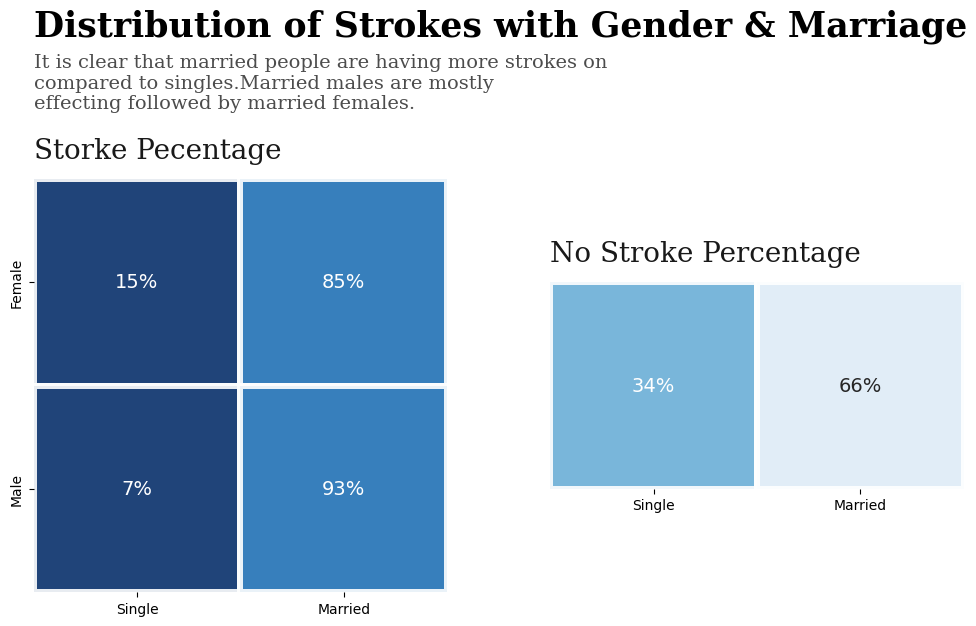

In [13]:


fig = plt.figure(figsize=(12,6),dpi = 100)
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])



# ever_married, gender, residence, heart_disease and work_type

healthy = df_stroke[df_stroke['stroke']==0]
stroke = df_stroke[df_stroke['stroke']==1]


col1 = ["#08306b","#2171b5"]
colormap1 = mt.colors.LinearSegmentedColormap.from_list("", col1, N = 256)
col2 = ["#6baed6","#deebf7"]
colormap2 = mt.colors.LinearSegmentedColormap.from_list("", col2)

stroke = pd.crosstab(stroke['gender'],[stroke['ever_married']],normalize='index')
no_stroke = pd.crosstab(healthy['gender'],[healthy['ever_married']], normalize='index')

sns.heatmap(ax=ax0, data=stroke, linewidths= 0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col1,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)

sns.heatmap(ax=ax1, data=no_stroke[0:-1], linewidths=0, 
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col2,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)

ax0.text(0, -0.69, 'Distribution of Strokes with Gender & Marriage', {'font':'Serif', 'color':'black', 'weight':'bold','size':25})
ax0.text(0, -0.34, 'It is clear that married people are having more strokes on \ncompared to singles.Married males are mostly \neffecting followed by married females.', {'font':'Serif', 'color':'black','size':14}, alpha = 0.7)

ax0.text(0,-0.1,'Storke Pecentage ', {'font':'serif', 'color':"black", 'size':20},alpha = 0.9)
ax1.text(0,-0.1,'No Stroke Percentage', {'font':'serif', 'color':"black", 'size':20}, alpha =0.9)

ax0.axes.set_xticklabels(['Single', 'Married'])
ax1.axes.set_xticklabels(['Single', 'Married'])

ax0.axes.set_yticklabels(['Female', 'Male'])


ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)
fig.show()


<Axes: xlabel='avg_glucose_level'>

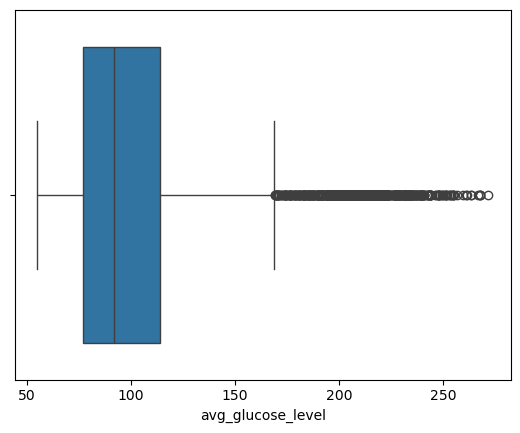

In [66]:
#Outliers exist for avg_glucose_level which needs to be handled
sns.boxplot(x='avg_glucose_level',data=df_stroke)

<Axes: xlabel='age', ylabel='bmi'>

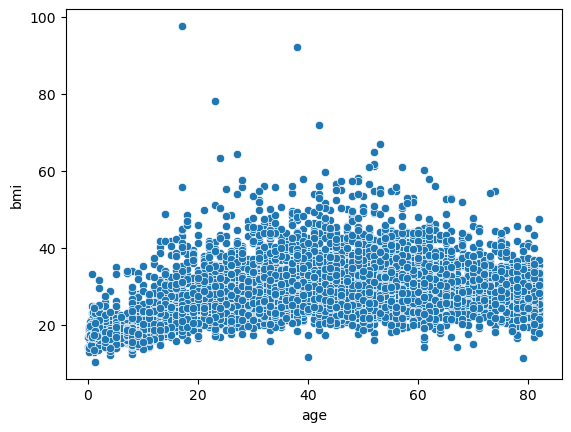

In [13]:
#Outliers exist for bmi which needs to be handled before proceeding with model building

sns.scatterplot(data= df_stroke, x= 'age',y='bmi',legend='brief')

### Key Insights
Using Exploratory Data Analysis (EDA), we gained a deeper understanding of the dataset, which will guide the subsequent model-building process.

- Age: The data ranges from 0 to approximately 80 years, with no visible outliers. Analysis reveals that the risk of stroke increases with age.
- 	Average Glucose Level: Outliers are evident, with several values exceeding 200, indicating potential anomalies or extreme cases.
-	BMI: Similar to glucose levels, BMI contains outliers, with a few values exceeding 50.
-	Stroke Distribution: The target variable, Stroke, has values 0 (No Stroke) and 1 (Stroke). The dataset exhibits a class imbalance, with significantly more 0s than 1s.
-	Ever Married: Married individuals show a higher likelihood of stroke occurrence compared to unmarried individuals.
To improve model performance and ensure consistency, it is essential to handle outliers effectively by standardizing and scaling the data before model building.


From above scatterplot we can see the BMI distribution across all the age groups in the given data.
In General Healthy BMI ranges from 18.5 to 24.9.However we can the most of the data indicates BMI >25 which is a clear indication that people are obese and following unhealthy lifestyle, in future they may be affected with any kind of diseases ex:Stroke,Heart Disease.


In [106]:
#Perform one hot encoding for all the categorical values and reduce the dimensionality by removing columns which are not useful for our model
import numpy as np
from sklearn.preprocessing import OneHotEncoder

df_enc = pd.get_dummies(df_stroke,columns=['gender','ever_married','work_type','Residence_type','smoking_status'],dtype='int',drop_first=True)
df_enc.columns


Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

In [107]:
#Scaling
df_enc['age'] = df_enc['age'].apply(lambda x: np.log(x+10)*3)
df_enc['avg_glucose_level'] = df_enc['avg_glucose_level'].apply(lambda x: np.log(x+10)*2)
df_enc['bmi'] = df_enc['bmi'].apply(lambda x: np.log(x+10)*2)



C:\Users\gamer\AppData\Local\Temp\ipykernel_16984\841845.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


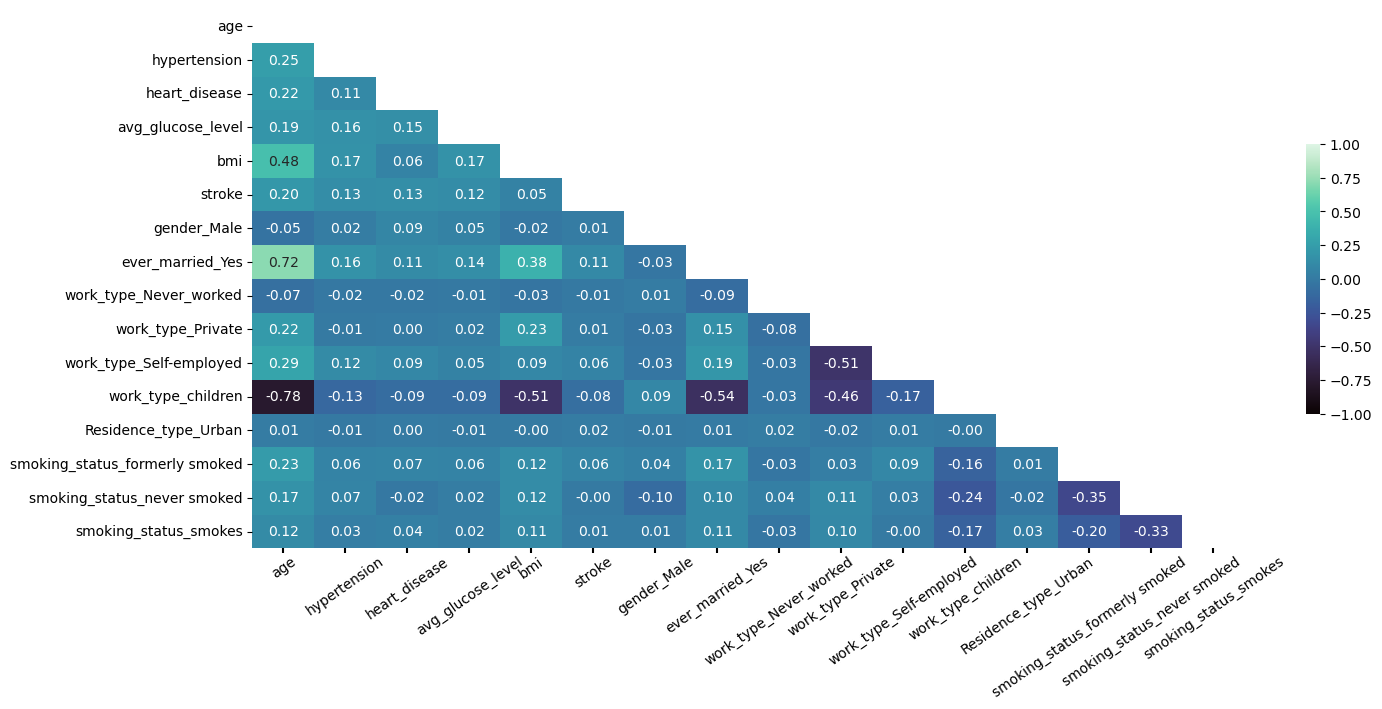

In [108]:
#Scale -1 to +1 for correlation 
import numpy as np
corr = df_enc.corr()
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize = (16,7))
#plt.figure(figsize = (16,7))

sns.heatmap(corr,cmap = 'mako',  annot=True, mask=matrix, fmt=".2f",
           vmin=-1, vmax=1, cbar_kws={"shrink": .5, })
ax.tick_params(axis = 'x', width=1.5,pad=0.5,rotation=35)
fig.show()

Lets drop the column Work_type_childer to remove the multi collinearity

In [109]:
#Split the data into training and testing 

df_model = df_enc
X=df_model.drop(['stroke','work_type_children'],axis=1)
y=df_model['stroke']

#Split the data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=53)

print("Train",X_train.shape,y_train.shape)
print("Test",X_test.shape,y_test.shape)

Train (3576, 14) (3576,)
Test (1533, 14) (1533,)


In [110]:
X.isna().sum()

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_Male                       0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
Residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [111]:
def prepare_data(X_train,X_test):
    object_columns = X_train.select_dtypes(include=["object"]).columns
    X_train_enc = X_train
    X_test_enc = X_test
    oe = OrdinalEncoder()
    oe.fit(X_train[object_columns])
    X_train_enc[object_columns] = oe.transform(X_train[object_columns])
    X_test_enc[object_columns] = oe.transform(X_test[object_columns])
    return X_train_enc,X_test_enc

def prepare_Target(y_train,y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc,y_test_enc

#Perform different encoding techniques for the data
X_train_enc,X_test_enc = prepare_data(X_train,X_test)
y_train_enc,y_test_enc = prepare_Target(y_train,y_test)

In [112]:
metrics=[]

Here are the breif description about the different metrics we use to evaluate the model performance:

1) Recall - It measures how manyh actual stroke cases acutally caught (Higher value is best ideally >0.85)

2) Precision - Precision checks if your model is learning patterns or just guessing Yes too often
 Ex - If model A and Model B both have 85% recall, but Model A has 15% precision & Model B has 5% precision, Model A is strictly a better because if creates a less false alarms.

3) F2-Score - It combines Recall and Precision into one number, but it mathematically treats Recall as twice as important as Precision
    It penalizes models that miss strokes heavily, while only lightly penalizing models that give false alarms


Here is how we pick the best model:-
1) we eliminate the model with Recall < 75%

2) sort the remaining models using F2-score 

3) Pick the model with high precision


--- Logistic Regression ---
Confusion Matrix:
 [[1018  440]
 [  13   62]]

--- Random Forest ---
Confusion Matrix:
 [[1456    2]
 [  75    0]]

--- Gradient Boosting ---
Confusion Matrix:
 [[1453    5]
 [  73    2]]

--- XGBoost ---
Confusion Matrix:
 [[1144  314]
 [  27   48]]


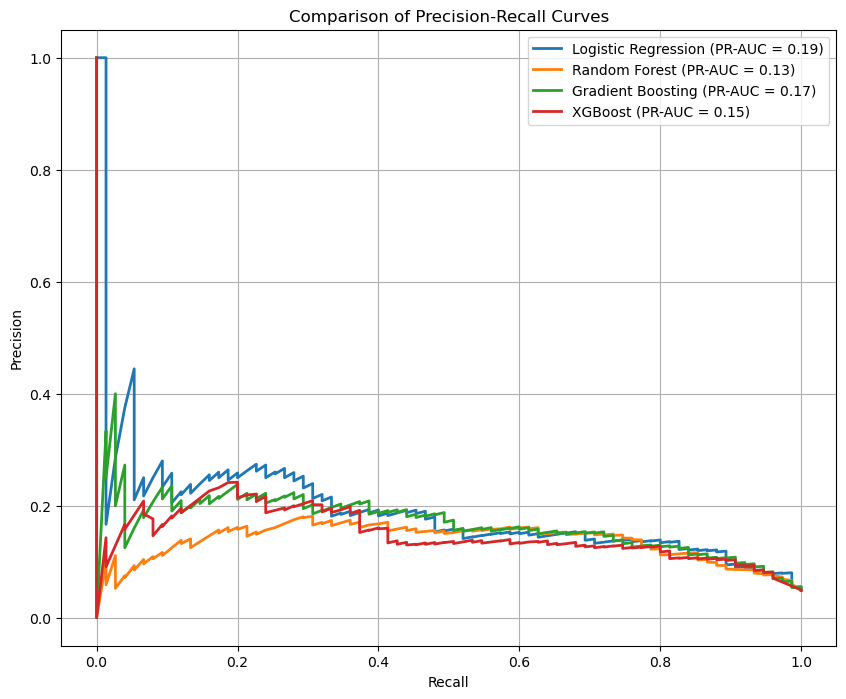

In [113]:
#Before SMOTE
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=48,max_iter=2500),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_jobs=10, criterion="entropy", n_estimators=1000),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(learning_rate=0.01, scale_pos_weight=19)
}


plt.figure(figsize=(10, 8))


for name, model in models.items():
    # Train the model
    model.fit(X_train_enc, y_train_enc)
    
    # Get the predicted probabilities
    y_prob = model.predict_proba(X_test_enc)[:, 1]
    
    # Calculate Precision-Recall Curve points
    precision, recall, thresholds = precision_recall_curve(y_test_enc, y_prob)
    pr_auc = auc(recall, precision)
    y_pred =model.predict(X_test_enc)
    plt.plot(recall, precision, lw=2, label=f'{name} (PR-AUC = {pr_auc:.2f})')
    #y_pred = (y_prob > 0.5).astype(int)
    print(f"\n--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test_enc, y_pred))
    
    metrics.append({
        "Model": name ,
        "Accuracy": round(accuracy_score(y_test_enc, y_pred), 2),
        "Precision": round(precision_score(y_test_enc, y_pred), 2),
        "Recall": round(recall_score(y_test_enc, y_pred), 2),
        "F1_macro": round(f1_score(y_test_enc, y_pred, average='macro'), 2),
        "F2_Score":round(fbeta_score(y_test_enc, y_pred, beta=2),2)
    })


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparison of Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()
    
    




In [114]:
pd.DataFrame(metrics)

,Model,Accuracy,Precision,Recall,F1_macro,F2_Score
0,Logistic Regression,0.70,0.12,0.83,0.52,0.39
1,Random Forest,0.95,0.00,0.00,0.49,0.00
2,Gradient Boosting,0.95,0.29,0.03,0.51,0.03
3,XGBoost,0.78,0.13,0.64,0.54,0.36


## SMOTE 


--- Logistic Regression ---
Confusion Matrix:
 [[1034  424]
 [  17   58]]

--- Random Forest ---
Confusion Matrix:
 [[1324  134]
 [  58   17]]

--- Gradient Boosting ---
Confusion Matrix:
 [[1153  305]
 [  33   42]]

--- XGBoost ---
Confusion Matrix:
 [[1147  311]
 [  29   46]]


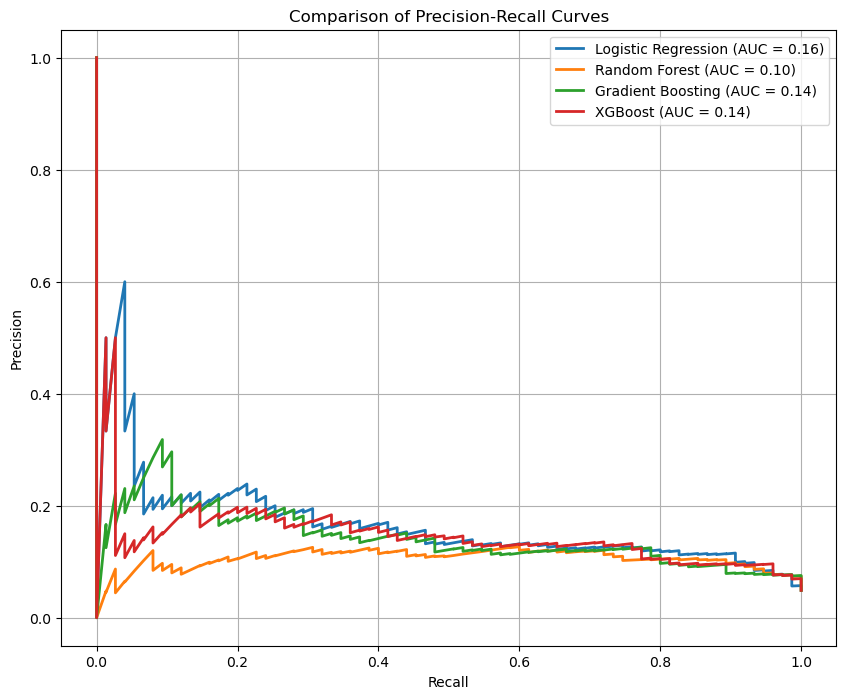

In [115]:
#Applying SMOTE(Synthetic Minority Oversampling Technique) technique helps us to balance the imbalance data
oversample = SMOTE()
X_smote,y_smote=oversample.fit_resample(X_train_enc,y_train_enc)

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42,max_iter=2500),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_jobs=10, criterion="entropy", n_estimators=1000),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(learning_rate=0.05)
}


plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train the model
    model.fit(X_smote,y_smote)
    
    # Get the predicted probabilities
    y_prob = model.predict_proba(X_test_enc)[:, 1]
    
    # Calculate Precision-Recall Curve points
    precision, recall, thresholds = precision_recall_curve(y_test_enc, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.2f})')
    #y_pred = (y_prob > 0.5).astype(int)
    y_pred =model.predict(X_test_enc)
    print(f"\n--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test_enc, y_pred))
    
    metrics.append({
        "Model": name + "(SMOTE)",
        "Accuracy": round(accuracy_score(y_test_enc, y_pred), 2),
        "Precision": round(precision_score(y_test_enc, y_pred), 2),
        "Recall": round(recall_score(y_test_enc, y_pred), 2),
        "F1_macro": round(f1_score(y_test_enc, y_pred, average='macro'), 2),
        "F2_Score":round(fbeta_score(y_test_enc, y_pred, beta=2),2)
    })


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparison of Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [116]:
pd.DataFrame(metrics)

,Model,Accuracy,Precision,Recall,F1_macro,F2_Score
0,Logistic Regression,0.70,0.12,0.83,0.52,0.39
1,Random Forest,0.95,0.00,0.00,0.49,0.00
2,Gradient Boosting,0.95,0.29,0.03,0.51,0.03
3,XGBoost,0.78,0.13,0.64,0.54,0.36
4,Logistic Regression(SMOTE),0.71,0.12,0.77,0.52,0.37
5,Random Forest(SMOTE),0.87,0.11,0.23,0.54,0.19
6,Gradient Boosting(SMOTE),0.78,0.12,0.56,0.54,0.32
7,XGBoost(SMOTE),0.78,0.13,0.61,0.54,0.35


Based on the evaluation metrics, Logistic Regression outperforms the other models, achieving the highest Recall and F2-score. For this analysis, we prioritized the Recall as our primary selection metric & F2-score as secondary metic (because it weights Recall twice as heavily as Precision). 

In critical medical diagnostics like stroke prediction, minimizing False Negatives (missing a stroke case) is paramount; therefore, a model that prioritizes high sensitivity is preferred over one that minimizes false alarms.

In [117]:
def plot_precision_recall_vs_threshold(model, X_test, y_test, model_name):
    # 1. Get the probabilities (not just the 0/1 predictions)
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # 2. Calculate the curve points
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    
    # 3. Plotting
    plt.figure(figsize=(10, 6))
    
    # Note: precision and recall have 1 extra element (0/1 starting points), 
    # so we use [:-1] to match the shape of thresholds.
    plt.plot(thresholds, precision[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recall[:-1], "g-", label="Recall", linewidth=2)
    
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.title(f"{model_name}: Precision and Recall vs Threshold", fontsize=14)
    plt.legend(loc="best", fontsize=12)
    plt.grid(True)
    
    plt.axvline(x=0.5, color='red', linestyle=':', label='Default 0.5 Threshold')
    
    plt.show()


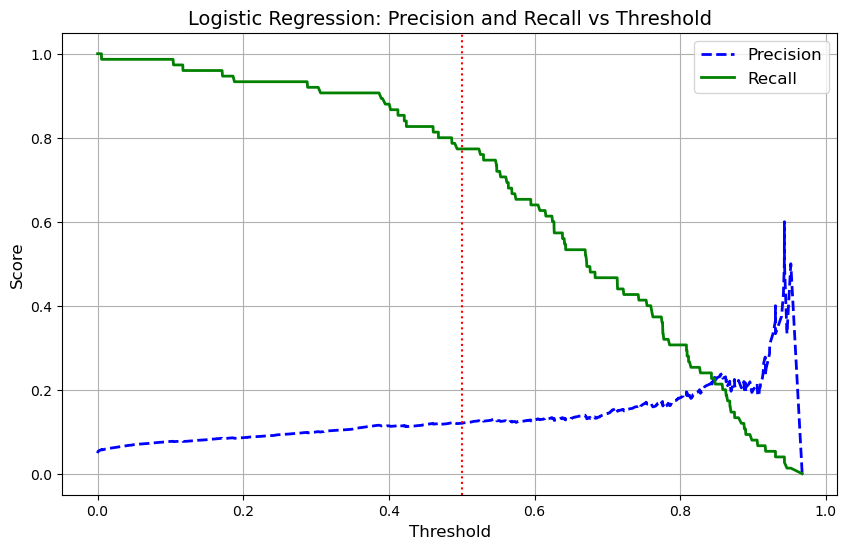

In [118]:
best_model = models["Logistic Regression"] 

plot_precision_recall_vs_threshold(best_model, X_test_enc, y_test_enc, "Logistic Regression")

In [119]:
pd.DataFrame(metrics)

,Model,Accuracy,Precision,Recall,F1_macro,F2_Score
0,Logistic Regression,0.70,0.12,0.83,0.52,0.39
1,Random Forest,0.95,0.00,0.00,0.49,0.00
2,Gradient Boosting,0.95,0.29,0.03,0.51,0.03
3,XGBoost,0.78,0.13,0.64,0.54,0.36
4,Logistic Regression(SMOTE),0.71,0.12,0.77,0.52,0.37
5,Random Forest(SMOTE),0.87,0.11,0.23,0.54,0.19
6,Gradient Boosting(SMOTE),0.78,0.12,0.56,0.54,0.32
7,XGBoost(SMOTE),0.78,0.13,0.61,0.54,0.35


### Model Performance Evaluation

1. Selection of Best Model: After evaluating multiple algorithms (Logistic Regression, Random Forest, XGBoost) under various conditions (Standard, SMOTE, and Weighted), Logistic Regression (Class Weighted) was identified as the superior model.

   - Recall (Sensitivity): 0.83 (The model detected 83% of actual stroke cases).

   -  F2-Score: 0.39 (The highest among all models).

2. The "Accuracy Paradox": Advanced tree-based models like Random Forest achieved high accuracy (95%) but failed critically on Recall (0.00). This indicates these models biased heavily toward the majority class (Healthy patients), effectively ignoring the stroke cases to maximize an overall accuracy score. This renders them unsuitable for medical screening.

3. Impact of SMOTE: Synthetic Minority Over-sampling Technique (SMOTE) was applied to balance the dataset. However, results showed that using the internal class_weight='balanced' parameter in Logistic Regression yielded better Recall (0.83) than SMOTE (0.77). Thus, the simpler, weighted approach was retained.


 Conclusion: We selected Logistic Regression as the final model because it prioritizes Recall. In a stroke prediction context, the cost of a False Negative (missing a stroke) is far higher than a False Positive (a false alarm). The chosen model ensures that the vast majority of at-risk patients are flagged for further medical review.


### Feature Importance

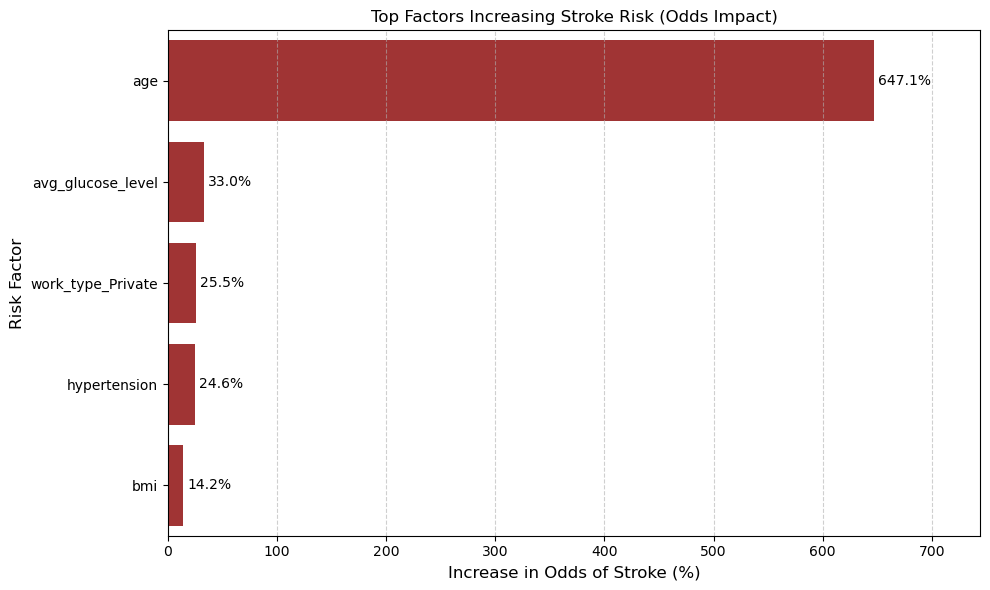

In [120]:
coeffs = best_model.coef_[0]
features = X_train_enc.columns

# 2. Calculate Odds Ratios and Percentage Change
df_risk = pd.DataFrame({'Feature': features, 'Coefficient': coeffs})
df_risk['Odds_Ratio'] = np.exp(df_risk['Coefficient'])
df_risk['Risk_Increase_%'] = (df_risk['Odds_Ratio'] - 1) * 100

# 3. FILTER: Keep only 'Risk Factors' (Positive Increase)
df_risk = df_risk[df_risk['Risk_Increase_%'] > 0]

# 4. Sort by Impact
df_risk = df_risk.sort_values(by='Risk_Increase_%', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Risk_Increase_%', y='Feature', data=df_risk, color='firebrick')

for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%', padding=3)

plt.title('Top Factors Increasing Stroke Risk (Odds Impact)', fontsize=12)
plt.xlabel('Increase in Odds of Stroke (%)', fontsize=12)
plt.ylabel('Risk Factor', fontsize=12)
plt.xlim(0, df_risk['Risk_Increase_%'].max() * 1.15)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The Feature Importance analysis (using Odds Ratios) reveals a clear hierarchy of risk factors, distinguishing between non-modifiable demographic traits and actionable lifestyle metrics.

1. The Dominant Factor: Age As illustrated in the results, Age is the overwhelming predictor of stroke events, showing a massive 647.1% increase in odds for the standardized unit increase. This confirms that stroke is primarily a condition associated with aging, and age remains the single strongest warning sign.

2. The "Modifiable" Risk Factors (Lifestyle Interventions) While age is unavoidable, the model isolates three critical biological markers that can be managed through lifestyle changes and medical intervention:

    - Glucose Levels: This is the most critical modifiable factor. Elevated average glucose levels are associated with a 33% increase in the odds of having a stroke.

    - Hypertension: A history of high blood pressure contributes to a 24.6% increase in stroke odds.

    - BMI: Higher Body Mass Index accounts for a 14.2% increase in risk.

3. Strategic Implication The data suggests that while we cannot stop aging, medical interventions targeting Blood Pressure (Hypertension) and Weight Management (BMI) are more effective than previously estimated. A combined strategy of glucose control, blood pressure management, and weight reduction offers the strongest protection against stroke.